In [6]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [7]:
RS = 42

In [8]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

corr = features.corr()

candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates



['gpmag', 'rpmag', 'ipmag', 'nuv_mag', 'Bmag']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state=RS, train_size=0.8)

cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1

class_weight = {0: 1, 1: 4}

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     12062
           1       0.15      0.21      0.17       935

    accuracy                           0.86     12997
   macro avg       0.54      0.56      0.55     12997
weighted avg       0.88      0.86      0.87     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


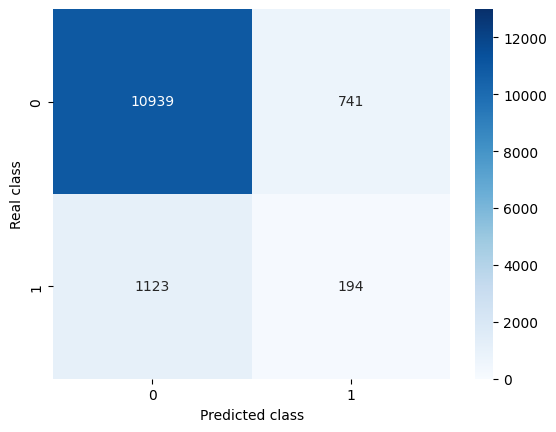

{'Accuracy': 0.8565822882203585,
 'Precision': 0.20748663101604278,
 'Recall': 0.14730447987851178,
 'F1': 0.17229129662522202}

In [14]:
clf = LogisticRegression(max_iter=300, class_weight=class_weight)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     12526
           1       0.12      0.32      0.17       471

    accuracy                           0.89     12997
   macro avg       0.54      0.62      0.55     12997
weighted avg       0.94      0.89      0.91     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


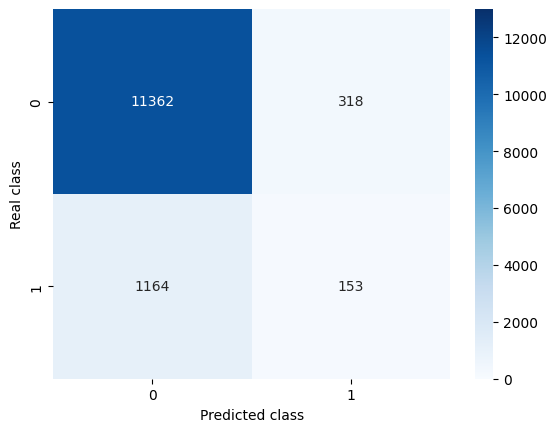

{'Accuracy': 0.885973686235285,
 'Precision': 0.3248407643312102,
 'Recall': 0.11617312072892938,
 'F1': 0.17114093959731544}

In [17]:
features_copy = features.copy()

for candidate in candidates[:-1]:
  features_copy.drop(candidate, inplace=True, axis=1)
  
X_train, X_test, Y_train, Y_test = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)

cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1

class_weight = {0: 1, 1: 4}

clf = LogisticRegression(max_iter=300, class_weight=class_weight)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     12526
           1       0.12      0.32      0.17       471

    accuracy                           0.89     12997
   macro avg       0.54      0.62      0.55     12997
weighted avg       0.94      0.89      0.91     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


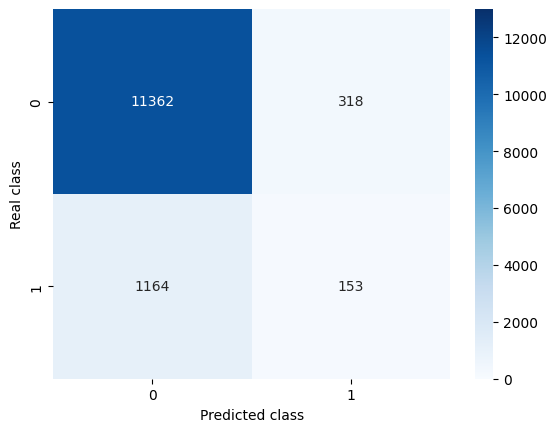

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     11570
           1       0.20      0.19      0.19      1427

    accuracy                           0.83     12997
   macro avg       0.55      0.55      0.55     12997
weighted avg       0.82      0.83      0.83     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


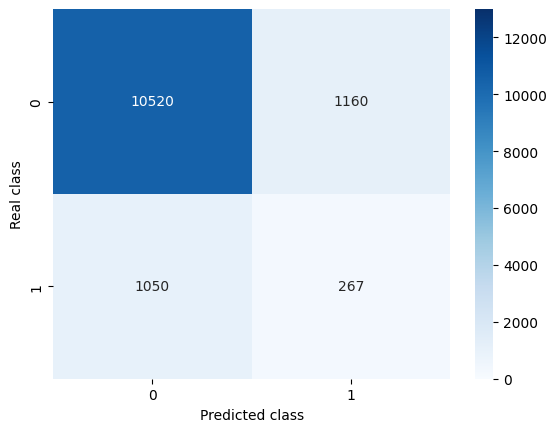

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      9744
           1       0.38      0.16      0.22      3253

    accuracy                           0.73     12997
   macro avg       0.57      0.54      0.53     12997
weighted avg       0.67      0.73      0.68     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


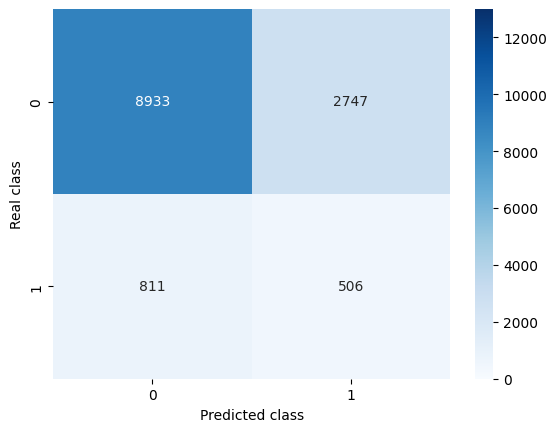

              precision    recall  f1-score   support

           0       0.58      0.93      0.71      7294
           1       0.60      0.14      0.22      5703

    accuracy                           0.58     12997
   macro avg       0.59      0.53      0.47     12997
weighted avg       0.59      0.58      0.50     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


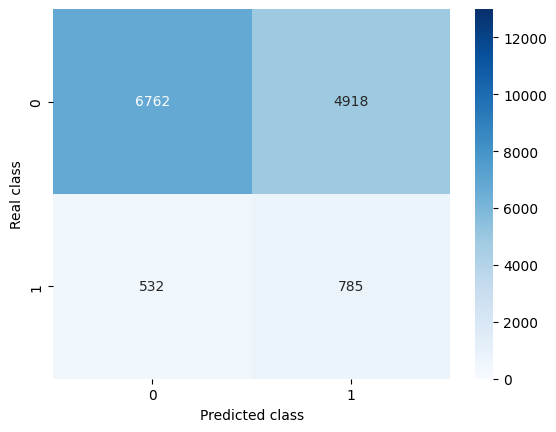

              precision    recall  f1-score   support

           0       0.37      0.94      0.53      4652
           1       0.77      0.12      0.21      8345

    accuracy                           0.41     12997
   macro avg       0.57      0.53      0.37     12997
weighted avg       0.63      0.41      0.33     12997



/home/arnautov/projectPractice/Stellar-classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


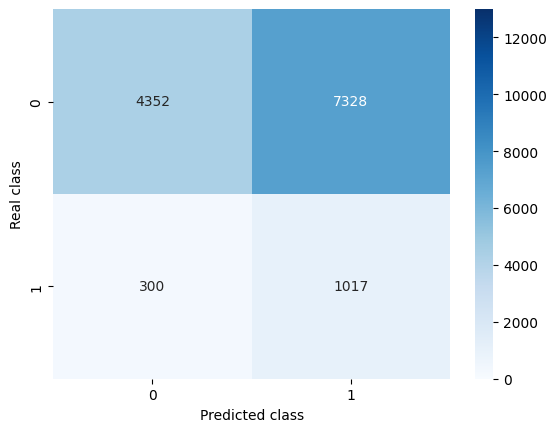

In [21]:
draw_data = []
for w in [4, 6, 8, 10, 12]:
  class_weight = {0: 1, 1: w}

  clf = LogisticRegression(max_iter=300, class_weight=class_weight)

  clf.fit(X_train, Y_train)

  pred = clf.predict(X_test)

  draw_data.append(metrics(pred, Y_test))
  draw_data[-1]["weight"] = w

Best weight for F1 score: 10. 
Best F1 score: 0.22364672364672364


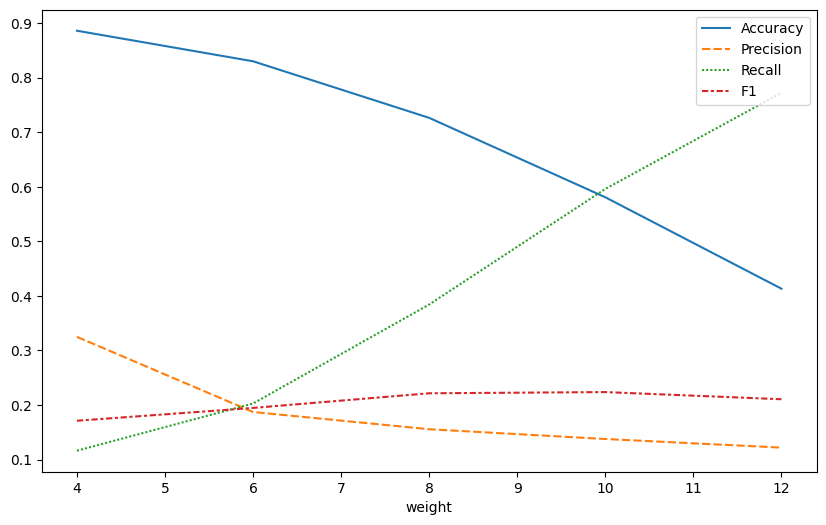

In [22]:
draw_df = pd.DataFrame(draw_data)
param_name = "weight"
draw_df = draw_df.set_index([param_name])

best_weight_f1 = draw_df["F1"].idxmax()
best_f1 = draw_df["F1"].max()

print(f"Best {param_name} for F1 score: {best_weight_f1}. \nBest F1 score: {best_f1}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")